# GlycoSHIELD WebApp Prototype

In [12]:
%load_ext autoreload
%autoreload 2

In [230]:
import numpy as np
import matplotlib

%matplotlib inline

In [2]:
import ipywidgets as widgets
from ipywidgets import Layout, Button, Box, VBox,HBox
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

In [237]:
import warnings
warnings.filterwarnings('ignore')

## Input File Upload

In [3]:
uploader = widgets.FileUpload(accept='*', multiple=True)
display(uploader)

FileUpload(value={}, accept='*', description='Upload', multiple=True)

In [108]:
for filename in uploader.value:
    with open(filename, 'wb') as fp:
        fp.write(uploader.value[filename]['content'])

## Computation

Define inputs




In [44]:
input = '''#
A 462,463,464 1,2,3 TUTORIAL/GLYCAN_LIBRARY/Man5.pdb TUTORIAL/GLYCAN_LIBRARY/Man5_dt1000.xtc A_463.pdb A_463.xtc
A 491,492,493 1,2,3 TUTORIAL/GLYCAN_LIBRARY/Man5.pdb TUTORIAL/GLYCAN_LIBRARY/Man5_dt1000.xtc A_492.pdb A_492.xtc
'''

TODO: 
* output file names A_463.pdb etc. are somehow bound to the protein chain, used later by glycoTRAJ. This should be fixed (prefix added automatically?)
* sequon numbers 462,463,464 and 1,2,3 -> for this version it shoul be just the central number, the rest is used by an undocumented option.
* Output should write into tmp_files, all of it.
* There should be more glycans available, fetched from ZENODO upon creation of the environment on binder
* Glycans should be defined as a dropdown.
* Whole input file should be written by a form, not by hand

In [45]:
path="./tmp_files/"

In [46]:
with open(path+"input_sugaring",'w') as f:
    f.write(input)


# GlycoSHIELD


In [291]:
from glycoshield.lib import glycoshield,glycotraj,glycosasa

In [195]:
pdbtraj=path+"test_pdb.pdb"
pdbtrajframes=30

gs = glycoshield(protpdb=path+'EC5.pdb',protxtc=None,inputfile=path+'input_sugaring',
                 pdbtraj=pdbtraj,pdbtrajframes=pdbtrajframes)
# gs = glycoshield(protpdb=path+'EC5.pdb',protxtc=path+"EC5_trj.pdb",inputfile=path+'input_sugaring')

/home/masikora/COLLAB_CYRIL1/WEBAPP/glycoshield-md/glycoshield/lib.py:282: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(inputs)


In [196]:
occ=gs.run()
print(occ)

Structure 0 residue 492: 100%|██████████| 3001/3001 [00:01<00:00, 2449.30it/s]


0 2619 1172
[[2619 1172]]


## GlycoTRAJ

In [201]:
maxframe=np.min(occ[0])
# Should deal with protein with xtc files separately but we dont need this functionality on the webapp
pdblist=gs.pdblist
xtclist=gs.xtclist
chainlist=gs.chainlist
reslist=gs.reslist
outname=path+"merged_traj"
pdbtraj=path+"test_merged_pdb.pdb"
pdbtrajframes=30
glycotraj(maxframe,outname,pdblist,xtclist,chainlist,reslist,pdbtraj,pdbtrajframes)

A 463
A 492


The merged trajectory (full) in xtc format and pdb trajectory trimmed to 'pdbtrajframes' first frames are in the tmp_files folder for the user to check/download

## GlycoSASA

<Figure size 432x288 with 0 Axes>

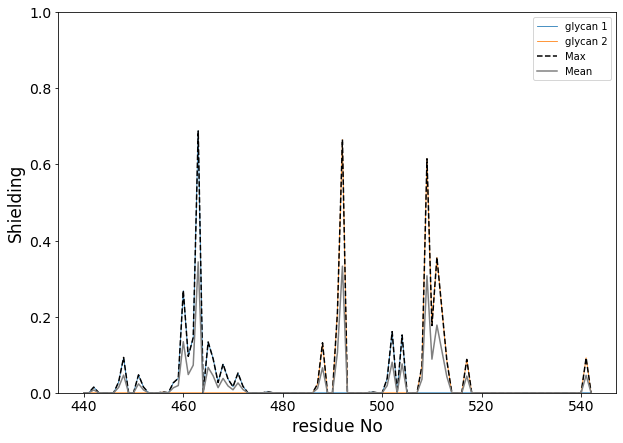

<Figure size 432x288 with 0 Axes>

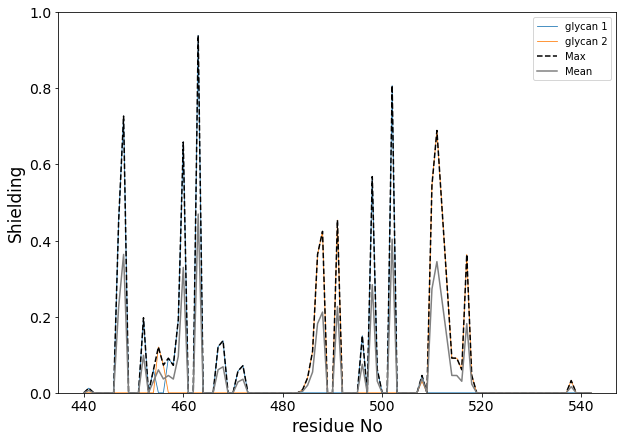

In [325]:
maxframe=np.min(occ[0])
maxframe=10 # temporary
pdblist=gs.pdblist
xtclist=gs.xtclist
probelist=[0.14,0.70] # Possibly user will have an option to choose one value, makes it faster and easier to manage visualisation
plottrace=True
ndots=15
mode="max"
keepoutput=False

sasas = glycosasa(pdblist=pdblist,xtclist=xtclist,plottrace=plottrace,
          probelist=probelist,ndots=ndots,mode=mode,keepoutput=keepoutput,maxframe=maxframe)

In [351]:
from glycoshield.NGL import NGLSASA
sasas=np.array(sasas)

myprobe=0.70
occupancy=sasas[sasas[:,4]==myprobe][0,5]
residues=sasas[sasas[:,4]==myprobe][0,0]
sasavis=NGLSASA(path="./",pdbfile='maxResidueSASA_probe_{}.pdb'.format(myprobe),occupancy=occupancy,residues=residues)
v1=sasavis.build_representation()
v1

NGLWidget()

End of SASA visualization.

In [109]:
class GSwidgets:
    def __init__(self):
        self.chains=["A","B","C"] # read out by mdanalysis
        self.residues=[1,2,3] # unique of all resids in the pdb file
        self.known_sugars=["Man5"] # Defined by the table in SI
        
    def create_chain_button(self):
        chain = widgets.Dropdown(
            options=self.chains,
            value=self.chains[0],
            description='Chain:',
            disabled=False,
            continuous_update=True,
        )
        return chain
    def create_residue_button(self):
        residue = widgets.Dropdown(
            options=self.residues,
            value=self.residues[0],
            description='Residue:',
            disabled=False,
            continuous_update=True,
        )
    def create_glycan_button(self):
        sugar = widgets.Dropdown(
            options=self.known_sugars,
            value=self.known_sugars[0],
            description='Glycan:',
            disabled=False,
            continuous_update=True,
        )
        return sugar
    
    def create_sampling_button(self):
        sampling = widgets.Dropdown(
            options=[200,1000],
            value=1000,
            description='Sampling:',
            disabled=False,
            continuous_update=True,
        )
        return sampling
 


In [110]:
# Here the idea will be to dynamically create user input fields. Either user selects No of sugars or there is a "add sugar" button. Either way it dynamically creates N rows of input fields

wg=GSwidgets()
button = widgets.Button(description="OK")
inp = widgets.Text(description='How many sugars to add:')
Box = widgets.HBox([inp,button])

def on_button_clicked(b):
    boxes=[]
    for sugar in range(int(inp.value)):
        b=wg.create_chain_button()
        boxes.append(HBox([b]))
    VBox(boxes)
button.on_click(on_button_clicked)
Box
# Ideas:
# https://stackoverflow.com/questions/37144216/ipywidgets-update-one-widget-based-on-results-from-another

In [111]:
button = widgets.Button(description="Click Me!")
inp = widgets.Text(description='text:')
Box = widgets.HBox([button,inp])

value_list = []

def on_button_clicked(b):
    value_list.append(inp.value)
    print(value_list)

button.on_click(on_button_clicked)
Box

['']


In [34]:
VBox([HBox([chain,residue,sugar,sampling]),HBox([chain,residue,sugar,sampling])])


In [ ]:
# glycoshield including gmx computation ...



## Visualization

In [7]:
# At the moment it uses preexisting files in the tmp_files folder

from glycoshield.NGL import NGL
path="./tmp_files/"
ngl=NGL(path=path)
ngl.add_sugar(path+'S_463.pdb',path+'S_463.xtc',20)
ngl.add_sugar(path+'S_492.pdb',path+'S_492.xtc',20)
ngl.add_sugar(path+'S_533.pdb',path+'S_533.xtc',20)
ngl.subsample()

/home/masikora/anaconda2/envs/my_root/lib/python3.7/site-packages/MDAnalysis/lib/mdamath.py:279: RuntimeWarning: invalid value encountered in double_scalars
  alpha = np.rad2deg(np.arccos(np.dot(y, z) / (ly * lz)))
/home/masikora/anaconda2/envs/my_root/lib/python3.7/site-packages/MDAnalysis/lib/mdamath.py:280: RuntimeWarning: invalid value encountered in double_scalars
  beta = np.rad2deg(np.arccos(np.dot(x, z) / (lx * lz)))
/home/masikora/anaconda2/envs/my_root/lib/python3.7/site-packages/MDAnalysis/lib/mdamath.py:281: RuntimeWarning: invalid value encountered in double_scalars
  gamma = np.rad2deg(np.arccos(np.dot(x, y) / (lx * ly)))
/home/masikora/anaconda2/envs/my_root/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:747: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "


In [8]:
v1=ngl.build_representation()
v1

#009392 1 A
#687588 2 A
#d0587e 3 A


NGLWidget()

In [21]:
import nglview
import ipywidgets
print(nglview.__version__,ipywidgets.__version__)

3.0.3 7.6.5


## Download of output files

In the left sidebar of the JupyterLab GUI, please right-click the file you want to download and select *Download*.

In [13]:
# A solution to have download buttons:
# https://stackoverflow.com/questions/61708701/how-to-download-a-file-using-ipywidget-button